In [1]:
# PATHS

DATA_DIR = '../data'
POSE_DIR = '../data/pose'

In [2]:
# REQUIRED IMPORTS FROM STANDARD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import random
import imageio
import os
import pandas as pd

from os.path import join as pjoin
from glob import glob

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from matplotlib import cm as cm


%load_ext autoreload
%autoreload 1

%aimport features_extraction
%aimport augmentation



## 1. Data exploration

The OpenPose feature format is explained at https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#keypoint-ordering. We use the BODY-25 model, and extract body (pose), face and hand keypoints,
for a total of 137. There are 25 pose, 70 face, and 2\*21 hand keypoints. Each keypoint has 3 values:
an `x` coordinate, an `y` coordinate, and a confidence value `c`.

We have converted the OpenPose files to more easily loaded numpy files for you. Below, we show how to use the `util` package to load and visualize these files.

In [3]:
# IMPORTS FROM THE UTIL LIBRARY PROVIDED BY US

import util.submission as S
import util.vis as V
import util.metrics as M


The original data consisted of video fragments in which exactly one sign is executed. Using OpenPose, the pose information was extracted for each frame of these videos. A sample therefore consists of sequence of poses. Each pose has fields for each body part: `pose`, `face`, `hand_left` and `hand_right`. 
For each body part, OpenPose extracts a number of important points (*keypoints*). Many of these correspond to a joint of the body (e.g., wrist, shoulder, ...). A keypoint is represented by its x- and y-coordinates in the image (`x` and `y`) and a confidence score `c`. This tells you how sure OpenPose was about this point. In the data set, this results in each body part being represented as a keypoint array, which has an `x` field, `y` field and `c` field. Each of these is a list of floating points, the length of which is determined by the body part (e.g., each hand has 21 keypoints).

In the code fragment below, we load the data for one training sample.

In [4]:
mat = np.load(pjoin(POSE_DIR, 'train/train_01181.npy'))
mat.shape

(8, 137, 3)

This function concatenates the keypoint information for all body parts. The order is: `pose`, `face`, `hand_left`, `hand_right`.

The result is a 3D numpy array. The first dimension of this array is the number of frames in the original video. The second dimension corresponds to the total number of keypoints and the third dimension (3) is the number of features per keypoint. The sequence loaded above is 8 frames long, it has 137 keypoints in total and 3 features (`x`, `y`, `c`) per keypoint. Accross different samples, the keypoints and features are always the same, but the number of frames depends on the time each sign took in the original videos.

As explained above, each body part has a different number of keypoints. They are structured in the numpy array as follows:

| Part       | Count | Start Index | End Index |
|------------|-------|-------------|-----------|
| pose       | 25    | 0           | 24        |
| face       | 70    | 25          | 94        |
| left hand  | 21    | 95          | 115       |
| right hand | 21    | 116         | 136       |

For example, we can extract the `x` coordinates of the keypoints of the left hand in the first frame:

In [5]:
hand_left_offset = 25 + 70 # pose + face
hand_left_len = 21
frame_index = 0
x_index = 0

hand_left_x = mat[frame_index, hand_left_offset:hand_left_offset + hand_left_len, x_index]

### 1.1. Exploring OpenPose features

The OpenPose features are arrays of floating point values, which indicate the location of each keypoint in the coordinate
system of the original image. Because we use input images of 455 by 256 pixels, the keypoint coordinates will also lie in this range.

In [6]:
pose = mat[0]
hand_left_x

array([269.395, 280.239, 289.693, 309.712, 296.922, 289.415, 299.424,
       308.044, 319.444, 296.644, 303.317, 311.937, 318.054, 303.039,
       306.098, 313.605, 317.776, 297.2  , 308.322, 310.824, 318.332])

Such an array is not very useful for visualisation purposes.

We therefore provide a visualisation module. It allows you to visualise individual poses using matplotlib.
Each body part has a different color.
Note that keypoints which were not detected by OpenPose are mapped to the origin at `(0, 0)` which is the top left corner of the image.

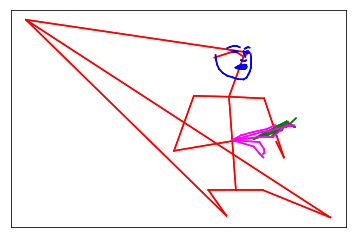

In [7]:
V.visualize(pose)

As you can see, certain keypoints are not detected... Also, the signer's left hand is oriented in such a way that many keypoints are very close together. Fortunately, this is usually not the case for all frames in a sign video.

## 1.3. Classes

There are 18 classes (signs) in the dataset. Each class corresponds to a different gloss (a gloss is a written representation of the meaning of a sign). For each class, we give the link to a video in the Flemish Sign Language dictionary. The classes are:

| Label | VGT Gloss     | English meaning | Example video URL                       |
|-------|---------------|-----------------|-----------------------------------------|
| 0     | AF            | Done, finished  | http://gebaren.ugent.be/movies/8826.mp4 |
| 1     | HEBBEN        | To have         | http://gebaren.ugent.be/movies/8290.mp4 |
| 2     | WAT           | What            | http://gebaren.ugent.be/movies/3019.mp4 |
| 3     | ZELFDE        | Same, identical | http://gebaren.ugent.be/movies/3172.mp4 |
| 4     | MOETEN        | Have to         | http://gebaren.ugent.be/movies/1650.mp4 |
| 5     | AUTORIJDEN    | To drive a car  | http://gebaren.ugent.be/movies/2150.mp4 |
| 6     | NAAR          | Towards         | http://gebaren.ugent.be/movies/791.mp4  |
| 7     | 1             | 1 (number)      | http://gebaren.ugent.be/movies/7922.mp4 |
| 8     | OOK           | Too, also       | http://gebaren.ugent.be/movies/8488.mp4 |
| 9     | ZEGGEN        | To say          | http://gebaren.ugent.be/movies/3169.mp4 |
| 10    | GOED          | Good            | http://gebaren.ugent.be/movies/927.mp4  |
| 11    | 2             | 2 (number)      | http://gebaren.ugent.be/movies/7959.mp4 |
| 12    | AANKOMEN      | To arrive       | http://gebaren.ugent.be/movies/7.mp4    |
| 13    | EERST         | First           | http://gebaren.ugent.be/movies/705.mp4  |
| 14    | ZIEN          | To see          | http://gebaren.ugent.be/movies/3182.mp4 |
| 15    | ECHT          | Real            | http://gebaren.ugent.be/movies/690.mp4  |
| 16    | JA            | Yes             | http://gebaren.ugent.be/movies/8325.mp4 |
| 17    | NIET          | Not             | http://gebaren.ugent.be/movies/1730.mp4 |

Note that 'VGT' stands for 'Vlaamse Gebarentaal' (*Flemish sign language*).

## 2. Assignment for stage 1 of the competition

Your first assignment is to:
- thoroughly analyse the dataset
- decide on a validation strategy
- decide on any preprocessing you would like to do
- try to come up with (and extract) many types of useful features from the data set
- come up with useful ways to augment your data and write functions for this

Ideally, you make a library that contains all your feature extractors as functions, each returning a *design matrix*, i.e. a matrix for which each row contains the features for one sample. The final version of this code must be submitted at the end of the project.

## 3. Data exploration

Below we load all the samples and we made some plots to gain more insights into our data

In [6]:
dataset_file=pjoin(DATA_DIR,'labels.csv')

label_count=np.zeros(18)
frame_count=np.zeros(18)
all_samples=[]
all_labels=[]
all_persons=[]

with open(dataset_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        name, _gloss, label, _person = row
        label_count[int(label)] += 1
        sample = np.load(pjoin(POSE_DIR, 'train', name+'.npy'))
        frame_count[int(label)] += sample.shape[0]
        all_samples.append(sample)
        all_labels.append(label)
        all_persons.append(_person)

all_labels=np.array(all_labels)
all_persons=np.array(all_persons)

In [10]:
def hands_passing_vertical(samplearray, finger1, finger2):
    #function checks how many times hands pass each other vertically
    ret_list = []
    for sample in samplearray:
        above = False
        count = 0
        for i in range(sample.shape[0]):
            confident = True
            if (sample[i][finger1][2] < 0.1 or sample[i][finger2][2] < 0.1): #check confidence levels
                confident = False
            if (i == 0):
                if ((sample[i][finger1][1] - sample[i][finger2][1]) < 0): #initalisation of function
                    above = True
            elif (((sample[i][finger1][1] - sample[i][finger2][1]) < 0) and not above and confident):
                count += 1
                above = True
            elif (((sample[i][finger1][1] - sample[i][finger2][1]) > 0) and above and confident):
                count += 1
                above = False
        ret_list.append(count)
    return ret_list

print("label 5")
print(hands_passing_vertical(all_samples[0:20], 99, 120))
print(hands_passing_vertical(all_samples[0:20], 103, 124))
print(hands_passing_vertical(all_samples[0:20], 107, 128))
print(hands_passing_vertical(all_samples[0:20], 111, 132))
print(hands_passing_vertical(all_samples[0:20], 115, 136))

print("label 14")
print(hands_passing_vertical(all_samples[281:301], 99, 120))
print(hands_passing_vertical(all_samples[281:301], 103, 124))
print(hands_passing_vertical(all_samples[281:301], 107, 128))
print(hands_passing_vertical(all_samples[281:301], 111, 132))
print(hands_passing_vertical(all_samples[281:301], 115, 136))

label 5
[0, 2, 2, 1, 0, 4, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2, 1, 0, 0, 0]
[0, 0, 2, 3, 0, 4, 3, 0, 0, 0, 0, 3, 0, 0, 4, 6, 0, 2, 0, 0]
[0, 1, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 0, 2, 1, 0]
[0, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 5, 8, 0, 2, 1, 0]
[0, 1, 2, 0, 2, 2, 2, 0, 4, 0, 0, 3, 0, 0, 3, 8, 0, 2, 3, 0]
label 14
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [24]:
def open_close_hands(samplearray, finger1, finger2):
    #function checks how many times hands touch each other
    ret_list = []
    for sample in samplearray:
        closed = False
        count = 0
        for i in range(sample.shape[0]):
            confident = True
            if (sample[i][finger1][2] < 0.1 or sample[i][finger2][2] < 0.1): #check confidence levels
                confident = False
            if (i == 0):
                if ((sample[i][finger1][0] - sample[i][finger2][0]) < 0 and (((sample[i][finger1][1] - sample[i][finger2][1]) < 0))): #initalisation of function
                    closed = True
            elif (((sample[i][finger1][0] - sample[i][finger2][0]) < 0) and not closed and confident and (((sample[i][finger1][1] - sample[i][finger2][1]) < 0))):
                count += 1
                closed = True
            elif (((sample[i][finger1][0] - sample[i][finger2][0]) > 0) and closed and confident and (((sample[i][finger1][1] - sample[i][finger2][1]) < 0))):
                count += 1
                closed = False
        ret_list.append(count)
    return ret_list

print("label 3")
print(open_close_hands(all_samples[1325:1345], 99, 120))
print(open_close_hands(all_samples[1325:1345], 100, 121)) 
print(open_close_hands(all_samples[1325:1345], 101, 122)) 
print(open_close_hands(all_samples[1325:1345], 102, 123))
print(open_close_hands(all_samples[1325:1345], 103, 124))
print("label 5")

print(open_close_hands(all_samples[0:20], 100, 121))
print("label 8")

print(open_close_hands(all_samples[2345:2365], 99, 120))
print(open_close_hands(all_samples[2345:2365], 100, 121))  
print(open_close_hands(all_samples[2345:2365], 101, 122)) 
print(open_close_hands(all_samples[2345:2365], 102, 123))
print(open_close_hands(all_samples[2345:2365], 103, 124))

#print(open_close_hands(all_samples[0:10], 120, 99)) #left thumb and right thumb 
print(all_labels[1325:1345])
print(all_labels[2345:2365])

                    

label 3
[1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
[1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[3, 0, 1, 0, 5, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3]
[3, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1]
[3, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
label 5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
label 8
[0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1]
[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0]
['3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3']
['8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8'
 '8' '8']


In [12]:
def thumb_pink_switch(samplearray, finger1, finger2):
    # Function checks if thumb and pink change positions
    ret_list = []
 
    for sample in samplearray:   
        switched = False
        smaller = False
        count = 0
        for i in range(sample.shape[0]):
            confident = True
            if (sample[i][finger1][2] < 0.01 or sample[i][finger2][2] < 0.01):
                confident = False
            if (i == 0): #initalisation of function
                if (sample[i][finger1][0] < sample[i][finger2][0]):
                    smaller = True
            elif ((sample[i][finger1][0] < sample[i][finger2][0]) and not smaller and confident): # other direction
                #switched = True
                count+=1
            elif ((sample[i][finger1][0] > sample[i][finger2][0]) and smaller and confident): # other direction
                #switched = True
                count+=1
        if (count > 2):
            switched = True
        if (switched):
            ret_list.append(1.0)
        else:
            ret_list.append(0.0)
    return ret_list
print(thumb_pink_switch(all_samples[0:20], 120, 136))
print(thumb_pink_switch(all_samples[0:20], 99, 115))
print(all_labels[0:10])
    

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
['5' '5' '5' '5' '5' '5' '5' '5' '5' '5']


Below you can find our code to generate a gif of the openpose frames.

In [9]:
a_hand = np.load('util/a_hand.npy')
a_face = np.load('util/a_face.npy')
a_body = np.load('util/a_body.npy')

def _plot_bodypart(adjacency, x, y, index_range, index_offset, color, pos):
    for i in index_range:
        for j in index_range:
            if i != j and adjacency[i, j] == 1:
                # The y coordinate is flipped, because the origin lies in the top left corner in OpenPose
                plt.plot([x[i + index_offset], x[j + index_offset]], [-1*y[i + index_offset], -1*y[j + index_offset]], c=color)


def visualize_png(pose, sample_id, frame_id, person_id, label):
    """
    Plot a pose using matplotlib and saved it as a png.

    :param pose: A numpy array of shape `(3, 137)`.
    """
    label_list = ['Done', 'To have', 'What', 'Same', 'Have to', 'To drive a car', 'Towards', '1', 'Too', 'To say', 'Good', '2', 'To Arrive', 'First', 'To see', 'Real', 'Yes', 'Not']
 

    x = pose[:, 0]
    y = pose[:, 1]

    fig = plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.title("sample: {}, label: {} {}, person: {}, frame: {}".format(sample_id, label, label_list[int(label)], person_id, frame_id))
    _plot_bodypart(a_body, x, y, range(25), 0, 'red', 'body')
    _plot_bodypart(a_face, x, y, range(70), 25, 'blue', 'face')
    _plot_bodypart(a_hand, x, y, range(21), 95, 'green', 'l_hand')
    _plot_bodypart(a_hand, x, y, range(21), 116, 'magenta', 'r_hand')
    label_path = 'plots/'+str(label)+'/'
    if not os.path.isdir(label_path):
        os.mkdir(label_path)
    path = 'plots/'+str(label)+'/'+str(sample_id)+'/'
    if not os.path.isdir(path):
        os.mkdir(path);
    plt.savefig(path+str(frame_id)+'.png')
    plt.close(fig)
    
def generate_png(begin_range, end_range):
    for i in range(begin_range, end_range + 1):
        for e in range(all_samples[i].shape[0]):
            visualize_png(all_samples[i][e], i, e, all_persons[i], all_labels[i])
        print("input {} done".format(i))

paths = 'plots/'

def generate_gif(begin_range, end_range):
    for file in range(begin_range, end_range + 1):
        images = []
        old_path = 'plots/'+str(all_labels[file])+'/'
        new_path = 'gifs/'+str(all_labels[file])+'/'
        if not os.path.isdir(new_path):
            os.mkdir(new_path)
        for filename in range(all_samples[file].shape[0]):
            images.append(imageio.imread(old_path+str(file)+'/'+str(filename)+'.png'))
        imageio.mimsave(new_path+str(file)+'.gif', images)


        
generate_png(251, 251)
generate_gif(251, 251)

input 251 done


A histogram which shows how many samples there are in the training data set, given the amount of frames of a sample:

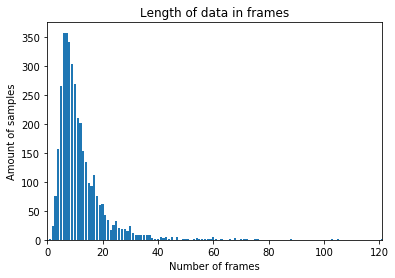

In [10]:
def plot_number_of_frames():
    test = [all_samples[i].shape[0] for i in range(len(all_samples))]
    x_max = max(test)
    y_val = [0 for i in range(x_max + 1)]
    for elt in test:
        y_val[elt] = y_val[elt] + 1
    
    plt.bar([i for i in range(x_max+1)], y_val)
    plt.xlim(0, 121)
    plt.xlabel("Number of frames")
    plt.ylabel("Amount of samples")
    plt.title("Length of data in frames")
    plt.show()
    #plt.savefig("Number_of_frames.png")


plot_number_of_frames()

Here we try to figure out if there is a class imbalance (which is the fact). We also plot the average amount of frames per label.

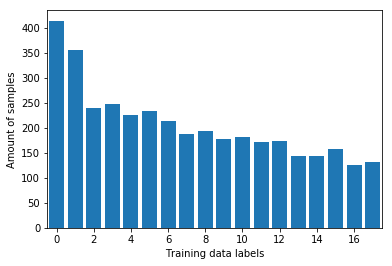

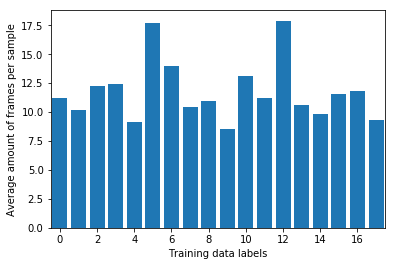

In [11]:
def plot_imbalance():
    plt.bar([i for i in range(18)], label_count)
    plt.xlim(-0.5,17.5)
    plt.xlabel("Training data labels")
    plt.ylabel("Amount of samples")
    plt.show()

def plot_avg_num_frames_per_label():
    for i in range(18):
        frame_count[i] = frame_count[i]/label_count[i]
        
    plt.bar([i for i in range(18)], frame_count)
    plt.xlim(-0.5,17.5)
    plt.xlabel("Training data labels")
    plt.ylabel("Average amount of frames per sample")
    plt.show()
    
plot_imbalance()
plot_avg_num_frames_per_label()

Here we analyze and plots the shifts (x,y) for the main keypoint of the hands per frame in every single sample. Besides, we store these plots per labels in order to analyze the shift of all samples with a same label.

In [7]:
# PATHS
#DATA_DIR: Folder where is located label.csv
#POSE_DIR= Folder that provide the pose train data
#PLOT_DIR =Folder that will store all the plots corresponding the displacement 
#           of the average keypoints of the hands per sample

data_set=pjoin(DATA_DIR,'labels.csv')
def readcsv(data_set,POSE_DIR):
    dataset_file=pjoin(DATA_DIR, 'labels.csv')
    label_count=np.zeros(18)
    frame_count=np.zeros(18)
    all_names=[]
    all_samples=[]
    all_labels=[]
    all_persons=[]
    with open(dataset_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        for row in reader:
            name, _gloss, label, _person = row
            label_count[int(label)] += 1
            sample = np.load(pjoin(POSE_DIR,'train', name+'.npy'))
            frame_count[int(label)] += sample.shape[0]
            all_names.append(name)
            all_samples.append(sample)
            all_labels.append(label)
            all_persons.append(_person)
    return all_names,all_samples,all_labels,all_persons


def analyze_shifts(POSE_DIR,DATA_DIR,PLOT_DIR,data_set):
    index_sample=0
    #Store names,labels and persons from csv
    all_names,all_samples,all_labels,all_persons=readcsv(data_set,POSE_DIR)
 
    for i,name in enumerate(listdir(POSE_DIR+'/train')):
        
        #Initial index
        indexFrame=0
        indexKeyPoint=0
        mat= np.load(pjoin(POSE_DIR,'train', name))
        
        #Array of Average movement in KeyPoints per sample
    #    1 dimension: Number of frames per sample
    #    2 dimension: x and y per Key Point
        arraykeyPointSamplesLeft=np.zeros((mat.shape[0],2))
        arraykeyPointSamplesRight=np.zeros((mat.shape[0],2))
        
        #Array of extracted KeyPoints per sample
    #    1 dimension: Number of keyPoints
    #    2 dimension: Number of frames per sample
    #    3 dimension: x and y per Key Point
        movementLeft=np.zeros((mat.shape[0],21,2))
        movementRight=np.zeros((mat.shape[0],21,2))
        #Extract KeyPoints on the hands
        for frame in mat:
            #Initial Index
            indexKeyPoint=0
            indexNewKeyPointLeft=0
            indexNewKeyPointRight=0
            #Extract Left Hand and Right Hand Keypoints
            for keyPoint in frame:
                #Left Hand
                if indexKeyPoint in range(95,116):
    #                print("range95.136" .format(indexKeyPoint))
                    movementLeft[indexFrame][indexNewKeyPointLeft][0]=keyPoint[0]
                    movementLeft[indexFrame][indexNewKeyPointLeft][1]=keyPoint[1]
                    indexNewKeyPointLeft=indexNewKeyPointLeft+1
                
                #Left Hand
                if indexKeyPoint in range(116,137):
    #                print("range95.136" .format(indexKeyPoint))
                    movementRight[indexFrame][indexNewKeyPointRight][0]=keyPoint[0]
                    movementRight[indexFrame][indexNewKeyPointRight][1]=keyPoint[1]
                    indexNewKeyPointRight=indexNewKeyPointRight+1
                indexKeyPoint=indexKeyPoint+1
            
             #Average of keypoints x,y per frame Left Hand
            for i in range(0,movementLeft[0].shape[0]):
                arraykeyPointSamplesLeft[indexFrame][0]+=movementLeft[indexFrame][i][0]
                arraykeyPointSamplesLeft[indexFrame][1]+=movementLeft[indexFrame][i][1]
                
            arraykeyPointSamplesLeft[indexFrame][0]=arraykeyPointSamplesLeft[indexFrame][0]/movementLeft[0].shape[0]
            arraykeyPointSamplesLeft[indexFrame][1]=arraykeyPointSamplesLeft[indexFrame][1]/movementLeft[0].shape[0]
           
            #Average of keypoints x,y per frame Right Hand
            for i in range(0,movementRight[0].shape[0]):
                arraykeyPointSamplesRight[indexFrame][0]+=movementRight[indexFrame][i][0]
                arraykeyPointSamplesRight[indexFrame][1]+=movementRight[indexFrame][i][1]
            
            arraykeyPointSamplesRight[indexFrame][0]=arraykeyPointSamplesRight[indexFrame][0]/movementRight[0].shape[0]
            arraykeyPointSamplesRight[indexFrame][1]=arraykeyPointSamplesRight[indexFrame][1]/movementRight[0].shape[0]
           
            indexFrame=indexFrame+1
            
        #PLOTS
        #PLOT x,y in left Hand
        fig = plt.figure()
        fig, axs = plt.subplots(2, 2)
        #Left Hand  X position
        offsetleftx=arraykeyPointSamplesLeft[0][0]
        dataleftx=np.zeros((arraykeyPointSamplesLeft.shape[0]))
        for i in range(arraykeyPointSamplesLeft.shape[0]):
            dataleftx[i]=(arraykeyPointSamplesLeft[i][0]-offsetleftx)
        #Yaxis=Frames per sample
        yaxis=np.arange(arraykeyPointSamplesLeft.shape[0])
        axs[0, 0].plot(yaxis,dataleftx)
        axs[0, 0].set_title('Shift X Sample :{} \n Left Hand ' .format(index_sample))
        axs[0, 0].set(xlabel='Frames',ylabel='Shift X')
        #Left Hand Y position
        offsetlefty=arraykeyPointSamplesLeft[0][1]
        datalefty=np.zeros((arraykeyPointSamplesLeft.shape[0]))
        for i in range(arraykeyPointSamplesLeft.shape[0]):
            datalefty[i]=(arraykeyPointSamplesLeft[i][1]-offsetlefty)
        #Yaxis=Frames per sample
        yaxis=np.arange(arraykeyPointSamplesLeft.shape[0])
        axs[0, 1].plot(yaxis,datalefty)
        axs[0, 1].set_title('Shift Y Sample :{} \n Left Hand ' .format(index_sample))
        axs[0, 1].set(xlabel='Frames',ylabel='Shift Y')
        
        #PLOT x,y in left Hand
        #Right Hand  X position
        offsetrightx=arraykeyPointSamplesRight[0][0]
        datarightx=np.zeros((arraykeyPointSamplesRight.shape[0]))
        for i in range(arraykeyPointSamplesRight.shape[0]):
            datarightx[i]=(arraykeyPointSamplesRight[i][0]-offsetrightx)
        #Yaxis=Frames per sample
        yaxis=np.arange(arraykeyPointSamplesRight.shape[0])
        axs[1, 0].plot(yaxis,datarightx)
        axs[1, 0].set_title(' Right Hand' .format(index_sample))
        axs[1, 0].set(xlabel='Frames',ylabel='Shift X')
        #Right Hand Y position
        offsetrighty=arraykeyPointSamplesRight[0][1]
        datarighty=np.zeros((arraykeyPointSamplesRight.shape[0]))
        for i in range(arraykeyPointSamplesRight.shape[0]):
            datarighty[i]=(arraykeyPointSamplesRight[i][1]-offsetrighty)
        #Yaxis=Frames per sample
        yaxis=np.arange(arraykeyPointSamplesRight.shape[0])
        axs[1, 1].plot(yaxis,datarighty)
        axs[1, 1].set_title(' Right Hand' .format(index_sample))
        axs[1, 1].set(xlabel='Frames',ylabel='Shift Y')
        
        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in fig.get_axes():
            ax.label_outer()
        
        #Save png in paths
        #Make dir per each label
        label_path = PLOT_DIR+'/'+str(all_labels[index_sample])+'/'
        if not os.path.isdir(label_path):
            os.mkdir(label_path)
        #Save the shifts per sample in the corresponding label
        plt.savefig(label_path+str(all_names[index_sample])+'.png')
        #plt.close(fig)
        
        index_sample+=1

analyze_shifts(POSE_DIR,DATA_DIR,PLOT_DIR,data_set)

NameError: name 'PLOT_DIR' is not defined

## Preprocessing
A preprocessing step we apply is centering, such that all samples are horizontally centerd in the middle of an openpose frame. The center of a person is based upon keypoint 1 of the pose.

In [ ]:
def centering(all_samples):
    center_frame = 455/2
     #do translations based on the pose of the first frame
    for sample_index in range(len(all_samples)):
        offset = all_samples[sample_index][0][1][0]-center_frame #always take first frame, and keypoint 1 of the pose to perform recentering
        for frame_index in range(len(all_samples[sample_index])):
            for keypoint_index in range(len(all_samples[sample_index][frame_index])):
                if all_samples[sample_index][frame_index][keypoint_index][0] != 0.0:
                    all_samples[sample_index][frame_index][keypoint_index][0] -= offset
    return all_samples

all_samples = centering(all_samples)

## Data augmentation

As augmentation we have the moving of the hands over small distances and scaling of the person with reference to a calculated point that corresponds to roughly the center of the person. We have not yet decided the parameters for these so here are some examples.

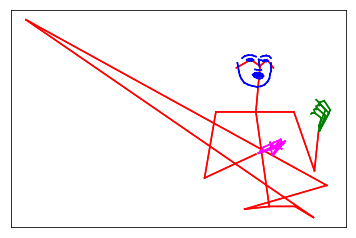

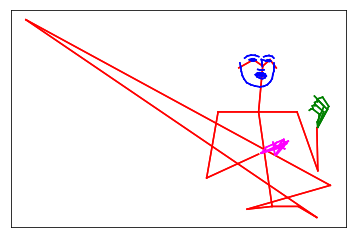

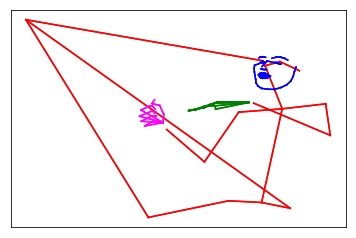

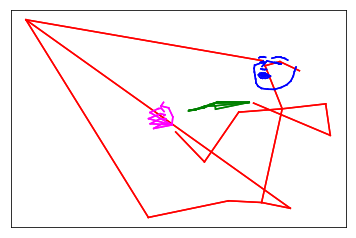

In [16]:
left_hand_augment = augmentation.move_left_hand(all_samples[15], -5, -4)
right_hand_augment = augmentation.move_right_hand(all_samples[18], 8, 3)

V.visualize(all_samples[15][0])
V.visualize(left_hand_augment[0])
V.visualize(all_samples[18][0])
V.visualize(right_hand_augment[0])

scaled_augment = augmentation.scale_person(all_samples[17], 1.2)


## 4. Feature extraction
We use our library 'feature_extraction' to compute the design matrix of all our training data and extract all our features out of the training data

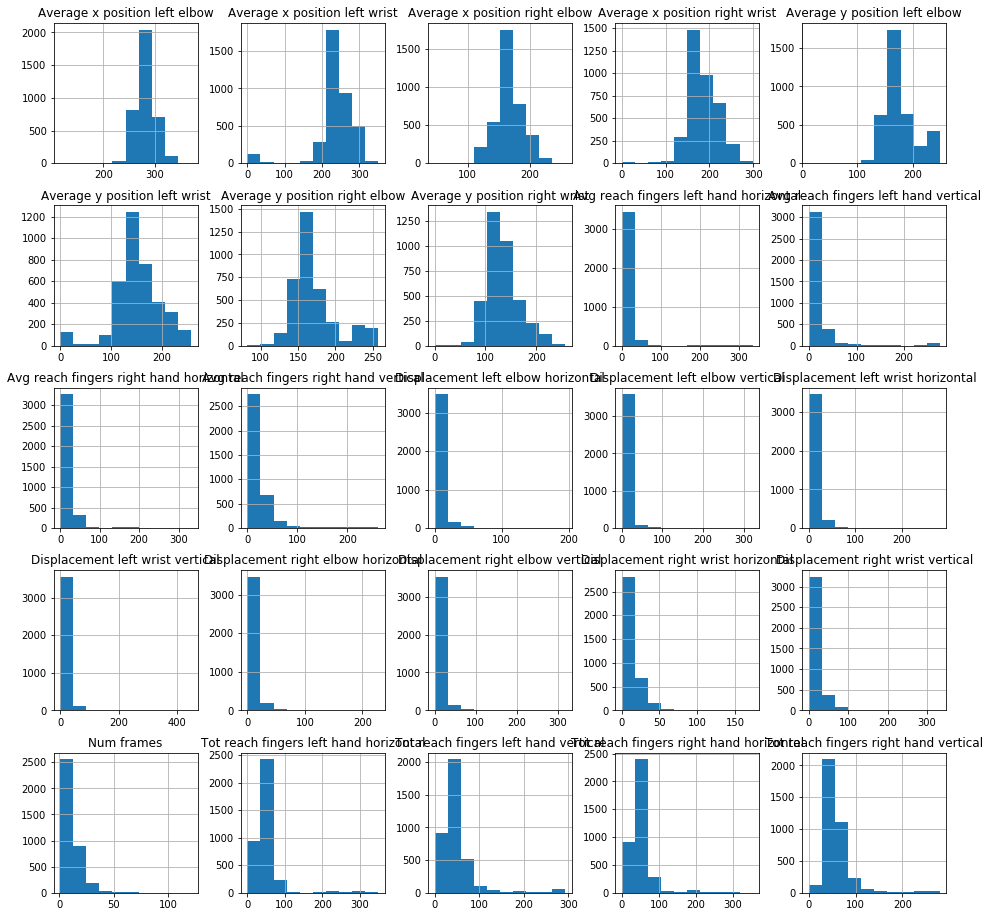

In [14]:
df_design_matrix = pd.DataFrame()
df_design_matrix['Avg reach fingers left hand horizontal'] = features_extraction.avg_reach_left_horizontal(all_samples)
df_design_matrix['Avg reach fingers left hand vertical'] = features_extraction.avg_reach_left_vertical(all_samples)
df_design_matrix['Avg reach fingers right hand horizontal'] = features_extraction.avg_reach_right_horizontal(all_samples)
df_design_matrix['Avg reach fingers right hand vertical'] = features_extraction.avg_reach_right_vertical(all_samples)
df_design_matrix['Tot reach fingers left hand horizontal'] = features_extraction.total_reach_left_horizontal(all_samples)
df_design_matrix['Tot reach fingers left hand vertical'] = features_extraction.total_reach_left_vertical(all_samples)
df_design_matrix['Tot reach fingers right hand horizontal'] = features_extraction.total_reach_right_horizontal(all_samples)
df_design_matrix['Tot reach fingers right hand vertical'] = features_extraction.total_reach_right_vertical(all_samples)
df_design_matrix['Num frames'] = features_extraction.get_frames(all_samples)
df_design_matrix['Displacement left wrist horizontal'] = features_extraction.keypoint_dist_l_x(all_samples, 7, 4)
df_design_matrix['Displacement left wrist vertical'] = features_extraction.keypoint_dist_l_y(all_samples, 7, 4)
df_design_matrix['Displacement right wrist horizontal'] = features_extraction.keypoint_dist_r_x(all_samples, 7, 4)
df_design_matrix['Displacement right wrist vertical'] = features_extraction.keypoint_dist_r_y(all_samples, 7, 4)
df_design_matrix['Displacement left elbow horizontal'] = features_extraction.keypoint_dist_l_x(all_samples, 6, 3)
df_design_matrix['Displacement left elbow vertical'] = features_extraction.keypoint_dist_l_y(all_samples, 6, 3)
df_design_matrix['Displacement right elbow horizontal'] = features_extraction.keypoint_dist_r_x(all_samples, 6, 3)
df_design_matrix['Displacement right elbow vertical'] = features_extraction.keypoint_dist_r_y(all_samples, 6, 3)
df_design_matrix['Average x position right wrist'] = features_extraction.average_x_keypoint(all_samples, 4)
df_design_matrix['Average y position right wrist'] = features_extraction.average_y_keypoint(all_samples, 4)
df_design_matrix['Average x position left wrist'] = features_extraction.average_x_keypoint(all_samples, 7)
df_design_matrix['Average y position left wrist'] = features_extraction.average_y_keypoint(all_samples, 7)
df_design_matrix['Average x position right elbow'] = features_extraction.average_x_keypoint(all_samples, 3)
df_design_matrix['Average y position right elbow'] = features_extraction.average_y_keypoint(all_samples, 3)
df_design_matrix['Average x position left elbow'] = features_extraction.average_x_keypoint(all_samples, 6)
df_design_matrix['Average y position left elbow'] = features_extraction.average_y_keypoint(all_samples, 6)
df_design_matrix.head()

df_design_matrix.hist(figsize = (16,16)) # figsize: (width,height)
plt.show()

Now we have all the feature values, we can plot a correlation matrix. Which shows the correlation between all our features. This will help us in making a decision when we perform feature selection

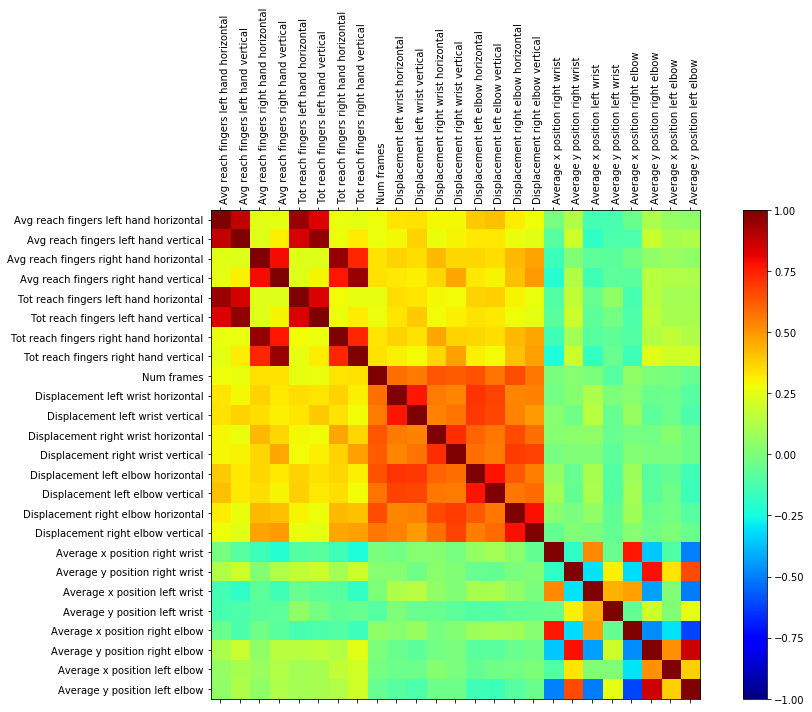

In [15]:
def plot_correlation_matrix(df):
    """Takes a pandas dataframe as input"""
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (14,10))
    plt.jet() # set the colormap to jet
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1)

    ticks = list(range(len(df.columns)))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticklabels(df.columns, rotation=90, horizontalalignment='left')
    ax.set_yticklabels(df.columns)
    
    fig.colorbar(cax, ticks=[-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])

    plt.tight_layout()
    plt.show()
    
plot_correlation_matrix(df_design_matrix)

